In [1]:
!pip install pycuda -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
!apt-get install -y nvidia-cuda-toolkit -q

In [ ]:
!nvidia-smi

Wed Nov  6 15:11:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

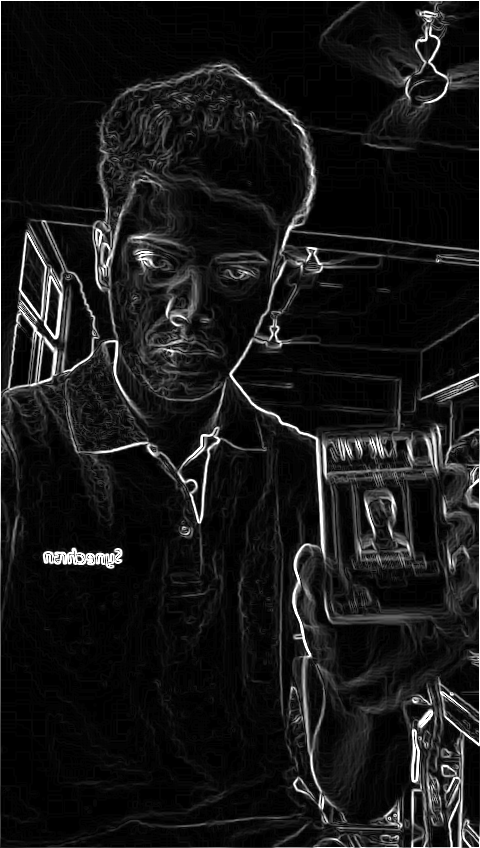

error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1367: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [ ]:
import cv2
import numpy as np
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
import time
from google.colab.patches import cv2_imshow


cap = cv2.VideoCapture('/content/my_vid.mp4')


if not cap.isOpened():
    print("Error: Could not open video")
    exit()

# Get frame size
ret, frame = cap.read()
height, width = frame.shape[:2]

# Define Sobel filter kernels in PyCUDA (for edge detection)
sobel_kernel = """
__global__ void sobel_filter(unsigned char *gray_img, unsigned char *output_img, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    int gx = 0;
    int gy = 0;

    int sobel_x[3][3] = {
        {-1, 0, 1},
        {-2, 0, 2},
        {-1, 0, 1}
    };

    int sobel_y[3][3] = {
        {-1, -2, -1},
        {0,  0,  0},
        {1,  2,  1}
    };

    for (int i = -1; i <= 1; i++) {
        for (int j = -1; j <= 1; j++) {
            if (x + i >= 0 && x + i < width && y + j >= 0 && y + j < height) {
                int pixel_val = gray_img[(y + j) * width + (x + i)];
                gx += sobel_x[i + 1][j + 1] * pixel_val;
                gy += sobel_y[i + 1][j + 1] * pixel_val;
            }
        }
    }

    int magnitude = sqrt(float(gx * gx + gy * gy));

    output_img[y * width + x] = magnitude > 255 ? 255 : magnitude;
}
"""

# Compile the kernel
mod = SourceModule(sobel_kernel)
sobel_filter = mod.get_function("sobel_filter")

# Prepare block and grid sizes
block_size = (16, 16, 1)
grid_size = (int(np.ceil(width / 16)), int(np.ceil(height / 16)), 1)

# Process the video
while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video")
        break

    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Allocate device memory for input and output images
    input_img_gpu = drv.mem_alloc(gray_frame.nbytes)
    output_img_gpu = drv.mem_alloc(gray_frame.nbytes)

    # Transfer grayscale image to GPU
    drv.memcpy_htod(input_img_gpu, gray_frame)

    # Allocate output array for the result
    output_img = np.zeros_like(gray_frame)

    # Launch Sobel filter on the GPU
    sobel_filter(input_img_gpu, output_img_gpu, np.int32(width), np.int32(height), block=block_size, grid=grid_size)

    # Copy the result back to the CPU
    drv.memcpy_dtoh(output_img, output_img_gpu)

    # Display the processed frame (optional for debugging)
    cv2_imshow(output_img)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object
cap.release()
cv2.destroyAllWindows()


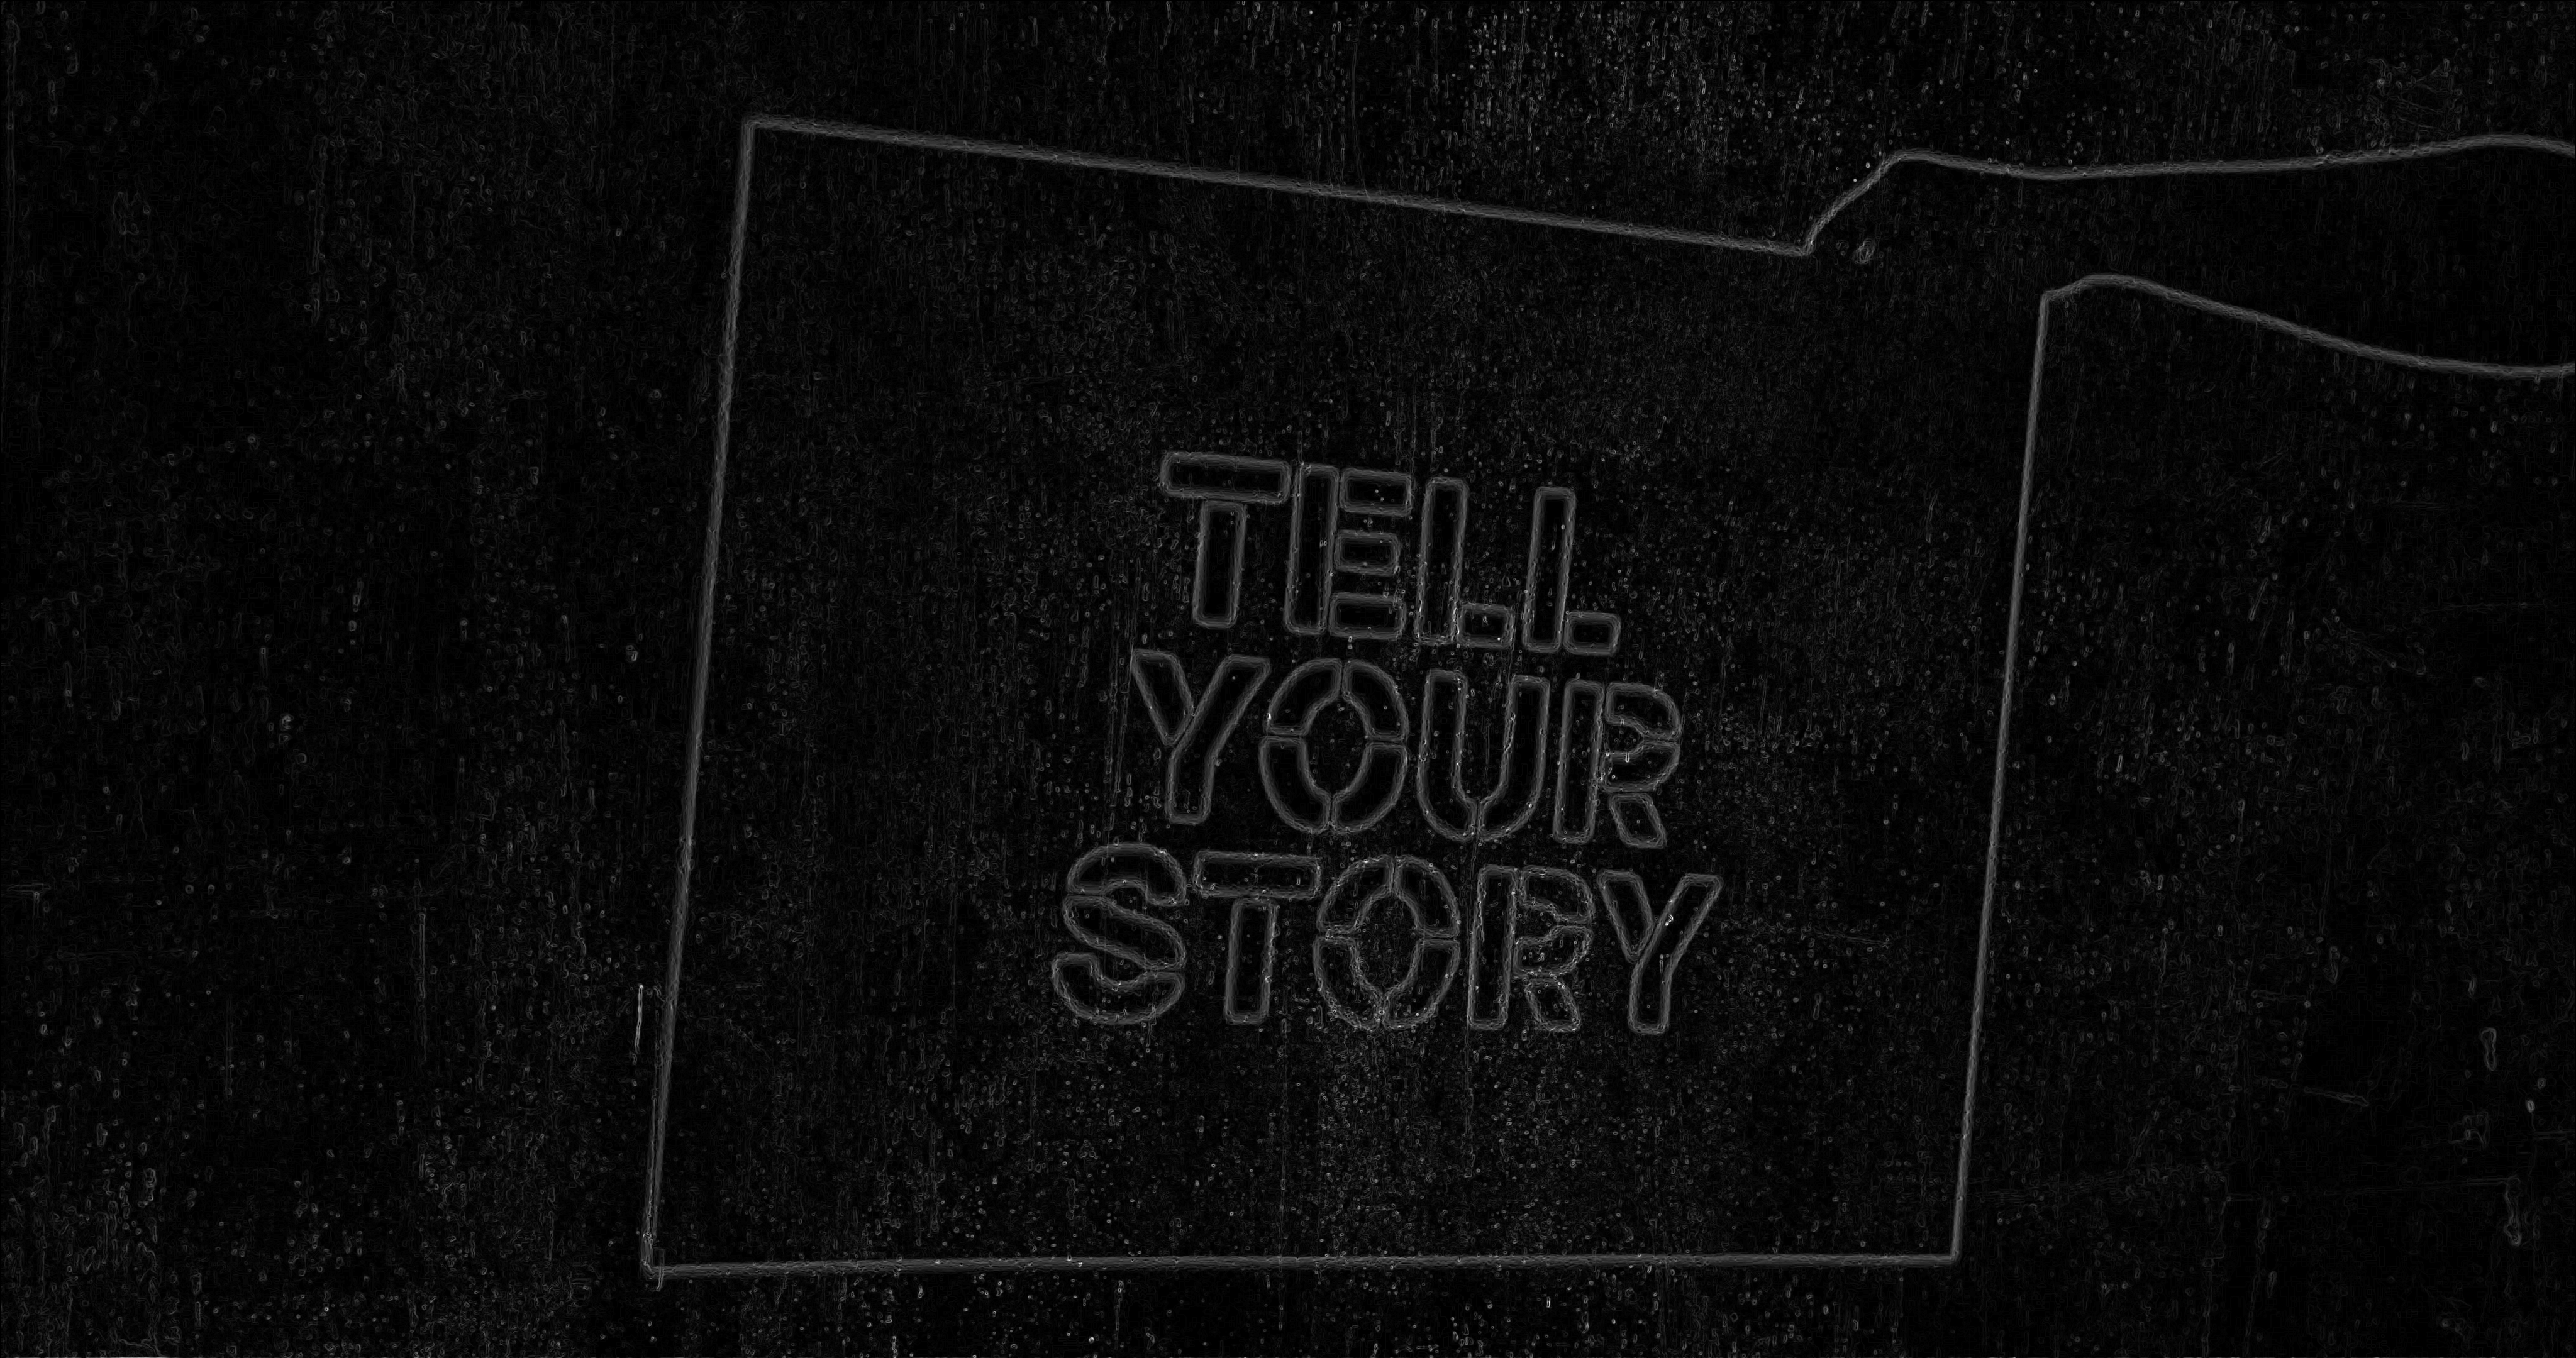

In [ ]:
import cv2
import numpy as np
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
import time
from google.colab.patches import cv2_imshow

# Load the uploaded video
cap = cv2.VideoCapture('/content/3831769-uhd_4096_2160_25fps.mp4')  # Replace with the video filename

# Ensure video was loaded
if not cap.isOpened():
    print("Error: Could not open video")
    exit()

# Get frame size
ret, frame = cap.read()
height, width = frame.shape[:2]

# Define Sobel filter kernels in PyCUDA (for edge detection) with shared memory for faster access
sobel_kernel = """
__global__ void sobel_filter(unsigned char *gray_img, unsigned char *output_img, int width, int height) {
    extern __shared__ unsigned char shared_img[];

    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    int tid = threadIdx.y * blockDim.x + threadIdx.x;
    shared_img[tid] = gray_img[y * width + x];

    __syncthreads();

    int gx = 0;
    int gy = 0;

    int sobel_x[3][3] = {
        {-1, 0, 1},
        {-2, 0, 2},
        {-1, 0, 1}
    };

    int sobel_y[3][3] = {
        {-1, -2, -1},
        {0,  0,  0},
        {1,  2,  1}
    };

    if (x >= 1 && x < width - 1 && y >= 1 && y < height - 1) {
        for (int i = -1; i <= 1; i++) {
            for (int j = -1; j <= 1; j++) {
                int pixel_val = gray_img[(y + j) * width + (x + i)];
                gx += sobel_x[i + 1][j + 1] * pixel_val;
                gy += sobel_y[i + 1][j + 1] * pixel_val;
            }
        }

        int magnitude = sqrt(float(gx * gx + gy * gy));
        output_img[y * width + x] = magnitude > 255 ? 255 : magnitude;
    }
}
"""

# Compile the kernel
mod = SourceModule(sobel_kernel)
sobel_filter = mod.get_function("sobel_filter")

# Prepare block and grid sizes (Increased block size for more GPU utilization)
block_size = (32, 32, 1)  # More threads per block
grid_size = (int(np.ceil(width / 32)), int(np.ceil(height / 32)), 1)

# Batch processing setup
batch_size = 10  # Number of frames to process together
frames_batch = []

# Process the video in batches
while True:
    # Load a batch of frames
    for _ in range(batch_size):
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames_batch.append(gray_frame)

    if len(frames_batch) == 0:
        print("End of video")
        break

    # Stack frames vertically for batch processing
    total_batch_size = len(frames_batch)
    combined_input = np.concatenate(frames_batch, axis=0)  # Stacks frames vertically

    # Allocate GPU memory for input and output images
    input_img_gpu = drv.mem_alloc(combined_input.nbytes)
    output_img_gpu = drv.mem_alloc(combined_input.nbytes)

    # Transfer batch to GPU
    drv.memcpy_htod(input_img_gpu, combined_input)

    # Allocate output array for the result
    output_img = np.zeros_like(combined_input)

    # Launch Sobel filter on the GPU
    batch_grid_size = (int(np.ceil(width / 32)), int(np.ceil(total_batch_size * height / 32)), 1)
    shared_mem_size = block_size[0] * block_size[1]  # Size of shared memory for each block
    sobel_filter(input_img_gpu, output_img_gpu, np.int32(width), np.int32(total_batch_size * height), block=block_size, grid=batch_grid_size, shared=shared_mem_size)

    # Copy the result back to the CPU
    drv.memcpy_dtoh(output_img, output_img_gpu)

    # Process each frame in the batch
    for i in range(total_batch_size):
        processed_frame = output_img[i * height:(i + 1) * height, :]
        cv2_imshow(processed_frame)

    # Clear the batch for the next set of frames
    frames_batch = []

# Release the video capture object
cap.release()
cv2.destroyAllWindows()


end



In [1]:
!pip install mistralai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 6.4 MB/s eta 0:00:00


In [2]:
from mistralai import Mistral
from google.colab import userdata
from PIL import Image
import requests
import os
import time
import base64
from io import BytesIO

mistral_api_key = userdata.get('MISTRAL_API_KEY')

client = Mistral(api_key=mistral_api_key)
model = "pixtral-12b-2409"


uploaded_image = '/content/test_image2.png'

if uploaded_image:

    image = Image.open(uploaded_image)
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()

    if image.mode == "RGBA":
        image = image.convert("RGB")



    def identify_monument():
        messages = [
                        {
                            "role": "user",
                            "content": [
                                {
                                    "type": "text",
                                    "text": 'You have been given image that has detected Edges from actual Image, your task is to identify any text in the image and return it.'
                                },
                                {
                                    "type": "image_url",
                                    "image_url": f"data:image/jpeg;base64,{img_str}"
                                }
                            ]
                        }
                    ]
        chat_response = client.chat.complete(
        model=model,
        messages=messages
        )

        result = chat_response.choices[0].message.content

        return result

    output = identify_monument()
    print (output)


The text identified in the image is "TELL YOUR STORY."


#Ignore


In [ ]:
!ngrok config add-authtoken 2niNrIdnEBqN9hdOBJYfD5PpqXe_85PKpiSdER1MuUF6wXwtV

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pip install streamlit pyngrok opencv-python-headless pycuda --quiet


In [ ]:
import subprocess
import time
from pyngrok import ngrok

# Save the Streamlit app code to 'app.py'
with open('app.py', 'w') as f:
    f.write("""
import streamlit as st
import cv2
import numpy as np
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

def streamlit_app():
    st.title("Edge Detection with PyCUDA")

    uploaded_file = st.file_uploader("Upload a video file", type=["mp4", "mov", "avi"])

    if uploaded_file is not None:
        file_bytes = np.frombuffer(uploaded_file.read(), np.uint8)
        video = cv2.VideoCapture(cv2.imdecode(file_bytes, cv2.IMREAD_COLOR))

        if not video.isOpened():
            st.write("Error: Could not open video")
            return

        stframe = st.empty()

        ret, frame = video.read()
        if ret:
            height, width = frame.shape[:2]

            sobel_kernel = \"\"\"
            __global__ void sobel_filter(unsigned char *gray_img, unsigned char *output_img, int width, int height) {
                int x = blockIdx.x * blockDim.x + threadIdx.x;
                int y = blockIdx.y * blockDim.y + threadIdx.y;

                if (x >= width || y >= height) return;

                int gx = 0;
                int gy = 0;

                int sobel_x[3][3] = {
                    {-1, 0, 1},
                    {-2, 0, 2},
                    {-1, 0, 1}
                };

                int sobel_y[3][3] = {
                    {-1, -2, -1},
                    {0,  0,  0},
                    {1,  2,  1}
                };

                for (int i = -1; i <= 1; i++) {
                    for (int j = -1; j <= 1; j++) {
                        if (x + i >= 0 && x + i < width && y + j >= 0 && y + j < height) {
                            int pixel_val = gray_img[(y + j) * width + (x + i)];
                            gx += sobel_x[i + 1][j + 1] * pixel_val;
                            gy += sobel_y[i + 1][j + 1] * pixel_val;
                        }
                    }
                }

                int magnitude = sqrt(float(gx * gx + gy * gy));
                output_img[y * width + x] = magnitude > 255 ? 255 : magnitude;
            }
            \"\"\"

            mod = SourceModule(sobel_kernel)
            sobel_filter = mod.get_function("sobel_filter")

            while True:
                ret, frame = video.read()
                if not ret:
                    break

                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                input_img_gpu = drv.mem_alloc(gray_frame.nbytes)
                output_img_gpu = drv.mem_alloc(gray_frame.nbytes)

                drv.memcpy_htod(input_img_gpu, gray_frame)

                output_img = np.zeros_like(gray_frame)

                block_size = (16, 16, 1)
                grid_size = (int(np.ceil(width / 16)), int(np.ceil(height / 16)), 1)
                sobel_filter(input_img_gpu, output_img_gpu, np.int32(width), np.int32(height), block=block_size, grid=grid_size)

                drv.memcpy_dtoh(output_img, output_img_gpu)

                stframe.image(output_img, channels="GRAY")

streamlit_app()
""")

# Start the Streamlit app
print("Starting Streamlit app...")
subprocess.Popen(["streamlit", "run", "app.py"])

# Wait a moment for the app to start
print("Waiting for Streamlit to launch...")
time.sleep(10)  # Increase delay for app to start

# Check if the Streamlit server is running
try:
    import requests
    response = requests.get("http://localhost:8501")
    if response.status_code == 200:
        print("Streamlit is running successfully.")
    else:
        print("Streamlit did not start correctly.")
except Exception as e:
    print(f"Error checking Streamlit status: {e}")

# Set up ngrok to tunnel the port 8501
public_url = ngrok.connect(8501)
print(f"Streamlit app is live at: {public_url}")


Starting Streamlit app...
Waiting for Streamlit to launch...
Streamlit is running successfully.
Streamlit app is live at: NgrokTunnel: "https://8b47-34-125-13-179.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!curl ifconfig.me


34.125.13.179